In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import sqlite3
# supervised model for labels

# Data Preprocessing
In the preprocessing phase, we began by retrieving data from our SQLite database, which houses tables related to housing, crime, and noise. We then merged these tables based on the 'CITY' and 'SITE_ADDRESS' fields to create a unified dataset for analysis. Next, we identified and removed any duplicate columns to clean the data and reduce redundancy. We also dropped any unnecessary columns to streamline the data further. For any missing values in the 'NOISE_CATEGORY' and 'AIR_NOISE' fields, we filled them with 0, operating under the assumption that these missing values indicate a lack of noise. Finally, to gain a better understanding of the data's inherent relationships, we created a heatmap to visualize the correlations between different features, aiding in our subsequent feature selection.

In [2]:
# Load the data
conn = sqlite3.connect('Wake_Housing.db')
join_housing_tables = '''
    SELECT *
    FROM housing
    LEFT JOIN crime ON housing.CITY = crime.CITY
    LEFT JOIN noise ON housing.SITE_ADDRESS = noise.SITE_ADDRESS
'''
house_crime_noise_df = pd.read_sql_query(join_housing_tables, conn)
conn.close()

house_crime_noise_df.head()

,index,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,...,TOTAL_VALUE,HEATED_AREA,SITE_ADDRESS,CITY,PLANNING_JURISDICTION,YEAR_BUILT,STYLE,ZIP_CODE,NOISE_CATEGORY,AIR_NOISE
0,0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,...,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN
1,1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,...,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN
2,2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,...,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN
3,3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,...,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN
4,4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,...,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN


In [3]:
house_crime_noise_df.dtypes

index                      int64
TOTAL_VALUE                int64
SITE_ADDRESS              object
CITY                      object
ZIP_CODE                   int64
PLANNING_JURISDICTION      int64
ZONING                   float64
ACREAGE                  float64
HEATED_AREA                int64
AGE                        int64
BATH                     float64
REMODEL_ADDITION           int64
STYLE                      int64
index                    float64
CITY                      object
PERSONAL_CHARGE_COUNT    float64
PERSONAL_NAME_COUNT      float64
PROPERTY_CHARGE_COUNT    float64
PROPERTY_NAME_COUNT      float64
DRUG_CHARGE_COUNT        float64
DRUG_NAME_COUNT          float64
TOTAL_CHARGE_COUNT       float64
TOTAL_NAME_COUNT         float64
index                    float64
TOTAL_VALUE              float64
HEATED_AREA              float64
SITE_ADDRESS              object
CITY                      object
PLANNING_JURISDICTION     object
YEAR_BUILT               float64
STYLE     

In [4]:
# Drop the unnecessary columns
house_crime_noise_df = house_crime_noise_df.loc[:,~house_crime_noise_df.columns.duplicated()]
house_crime_noise_df.dtypes

index                      int64
TOTAL_VALUE                int64
SITE_ADDRESS              object
CITY                      object
ZIP_CODE                   int64
PLANNING_JURISDICTION      int64
ZONING                   float64
ACREAGE                  float64
HEATED_AREA                int64
AGE                        int64
BATH                     float64
REMODEL_ADDITION           int64
STYLE                      int64
PERSONAL_CHARGE_COUNT    float64
PERSONAL_NAME_COUNT      float64
PROPERTY_CHARGE_COUNT    float64
PROPERTY_NAME_COUNT      float64
DRUG_CHARGE_COUNT        float64
DRUG_NAME_COUNT          float64
TOTAL_CHARGE_COUNT       float64
TOTAL_NAME_COUNT         float64
YEAR_BUILT               float64
NOISE_CATEGORY           float64
AIR_NOISE                float64
dtype: object

In [5]:
# Drop the unnecessary columns
house_crime_noise_df = house_crime_noise_df.drop(['index', 'YEAR_BUILT'], axis=1)
house_crime_noise_df

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,...,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT,NOISE_CATEGORY,AIR_NOISE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,NaN,NaN
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,NaN,NaN
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,NaN,NaN
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,...,69.0,49.0,68.0,42.0,61.0,29.0,198.0,120.0,NaN,NaN
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185926,137044,6237 TEN TEN RD,APEX,27539,13,NaN,1.18,1456,36,2.0,...,144.0,112.0,215.0,130.0,146.0,77.0,505.0,319.0,NaN,NaN
185927,474932,500 KENT DR,CARY,27511,2,NaN,1.77,3110,26,2.5,...,404.0,319.0,293.0,187.0,239.0,145.0,936.0,651.0,NaN,NaN
185928,235612,1305 PONDEROSA DR,RALEIGH,27603,13,NaN,2.07,1640,61,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,NaN,NaN
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,NaN,NaN


In [6]:
# Change null values in Noise Category and Air Noise to 0 as this is accurate for any address missing from noise_df
house_crime_noise_df['NOISE_CATEGORY'] = house_crime_noise_df['NOISE_CATEGORY'].fillna(0)
house_crime_noise_df['AIR_NOISE'] = house_crime_noise_df['AIR_NOISE'].fillna(0)
house_crime_noise_df

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,...,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT,NOISE_CATEGORY,AIR_NOISE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,...,69.0,49.0,68.0,42.0,61.0,29.0,198.0,120.0,0.0,0.0
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185926,137044,6237 TEN TEN RD,APEX,27539,13,NaN,1.18,1456,36,2.0,...,144.0,112.0,215.0,130.0,146.0,77.0,505.0,319.0,0.0,0.0
185927,474932,500 KENT DR,CARY,27511,2,NaN,1.77,3110,26,2.5,...,404.0,319.0,293.0,187.0,239.0,145.0,936.0,651.0,0.0,0.0
185928,235612,1305 PONDEROSA DR,RALEIGH,27603,13,NaN,2.07,1640,61,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0


In [7]:
house_crime_noise_df = house_crime_noise_df.dropna()
house_crime_noise_df

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,...,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT,NOISE_CATEGORY,AIR_NOISE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,...,69.0,49.0,68.0,42.0,61.0,29.0,198.0,120.0,0.0,0.0
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185922,212299,224 GOLDEN PLUM LN,ZEBULON,27597,16,4.0,0.17,1292,1,2.0,...,68.0,56.0,87.0,51.0,76.0,44.0,231.0,151.0,0.0,0.0
185923,526414,2736 ROSEDALE AVE,RALEIGH,27607,10,6.0,0.56,2328,56,2.5,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0
185924,55107,5816 WATKINS RD,WENDELL,27591,13,30.0,1.11,916,73,1.0,...,69.0,49.0,68.0,42.0,61.0,29.0,198.0,120.0,0.0,0.0
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,...,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0


<AxesSubplot:>

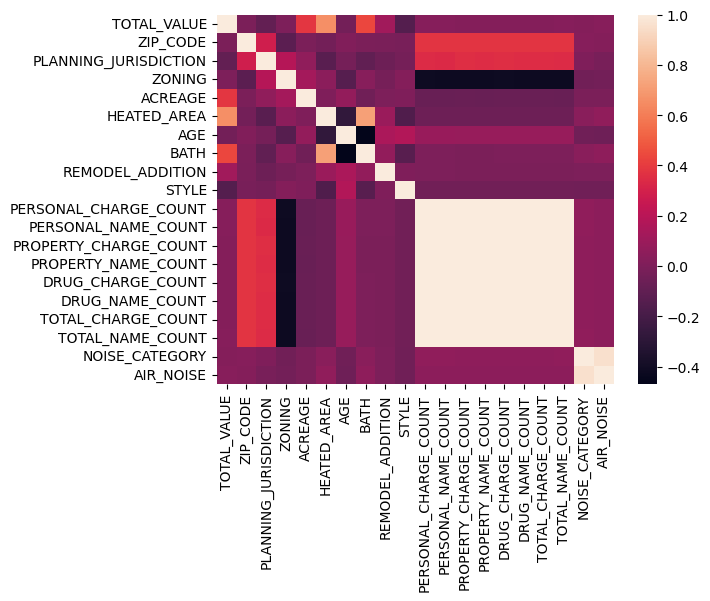

In [8]:
# https://stackoverflow.com/questions/39409866/correlation-heatmap
# Create a correlation heatmap to assess features for their significance
Var_Corr = house_crime_noise_df.corr()

# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False)

In [9]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

Var_Corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,TOTAL_VALUE,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,REMODEL_ADDITION,STYLE,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT,NOISE_CATEGORY,AIR_NOISE
TOTAL_VALUE,1.00,-0.01,-0.09,-0.00,0.38,0.66,-0.03,0.44,0.12,-0.15,0.02,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03
ZIP_CODE,-0.01,1.00,0.29,-0.13,-0.01,-0.04,0.01,-0.01,-0.01,-0.02,0.38,0.37,0.38,0.38,0.38,0.38,0.38,0.38,0.03,0.02
PLANNING_JURISDICTION,-0.09,0.29,1.00,0.19,0.06,-0.13,-0.03,-0.10,-0.06,-0.03,0.34,0.33,0.35,0.35,0.35,0.35,0.35,0.34,0.00,-0.02
ZONING,-0.00,-0.13,0.19,1.00,0.13,0.04,-0.14,0.03,-0.03,0.02,-0.42,-0.42,-0.42,-0.42,-0.42,-0.42,-0.42,-0.42,-0.04,-0.04
ACREAGE,0.38,-0.01,0.06,0.13,1.00,0.00,0.07,-0.05,-0.00,0.00,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.01,-0.01
HEATED_AREA,0.66,-0.04,-0.13,0.04,0.00,1.00,-0.28,0.71,0.10,-0.16,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,0.04,0.06
AGE,-0.03,0.01,-0.03,-0.14,0.07,-0.28,1.00,-0.47,0.15,0.17,0.09,0.09,0.09,0.09,0.08,0.08,0.09,0.09,-0.05,-0.05
BATH,0.44,-0.01,-0.10,0.03,-0.05,0.71,-0.47,1.00,0.07,-0.14,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,0.04,0.05
REMODEL_ADDITION,0.12,-0.01,-0.06,-0.03,-0.00,0.10,0.15,0.07,1.00,0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00
STYLE,-0.15,-0.02,-0.03,0.02,0.00,-0.16,0.17,-0.14,0.00,1.00,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.05,-0.05


# Feature Engineering and Selection

Our team was dedicated to carefully selecting and engineering features that would most accurately predict the total value of each house. We started with a variety of potential variables, some relating directly to the houses such as heated area, age, and number of bathrooms, and others providing context about the surroundings, like local crime rates and ambient noise levels.

We analyzed the correlations between all potential features and our target variable, represented visually in a correlation heatmap. This process highlighted that house-specific features like heated area, age, and acreage exhibited a strong correlation with house prices. On the other hand, crime rates and noise levels had weaker correlations. Yet, we included 'TOTAL_CHARGE_COUNT' and 'AIR_NOISE' in our model because we wanted to understand how these environmental factors could influence housing prices. Despite their lower correlations, we hypothesized that these aspects might subtly impact home buyer perceptions and hence, house values. This process has helped us to craft a model that not only considers the physical attributes of the homes but also takes into account the surrounding environmental factors.

In [10]:
# Select features we're interested in
features = ['HEATED_AREA', 'BATH', 'AGE', 'ACREAGE', 'ZIP_CODE', 'STYLE', 'REMODEL_ADDITION', 'PLANNING_JURISDICTION', 'ZONING', 'TOTAL_CHARGE_COUNT', 'AIR_NOISE']
X = house_crime_noise_df[features]
X

,HEATED_AREA,BATH,AGE,ACREAGE,ZIP_CODE,STYLE,REMODEL_ADDITION,PLANNING_JURISDICTION,ZONING,TOTAL_CHARGE_COUNT,AIR_NOISE
0,1828,2.0,59,0.21,27610,8,0,10,4.0,13426.0,0.0
1,1240,1.0,53,0.46,27610,0,0,10,4.0,13426.0,0.0
2,1037,2.0,24,0.43,27606,0,0,10,4.0,13426.0,0.0
3,2261,2.0,123,0.46,27591,0,0,14,3.0,198.0,0.0
4,996,1.0,67,0.51,27603,0,0,6,2.0,13426.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
185922,1292,2.0,1,0.17,27597,0,0,16,4.0,231.0,0.0
185923,2328,2.5,56,0.56,27607,8,0,10,6.0,13426.0,0.0
185924,916,1.0,73,1.11,27591,0,0,13,30.0,198.0,0.0
185929,3202,3.5,6,0.34,27607,0,0,10,4.0,13426.0,0.0


In [11]:
# 'TOTAL_VALUE' home cost is our target variable
y = house_crime_noise_df['TOTAL_VALUE']
y

0         249321
1         159933
2         222624
3         150723
4         140801
           ...  
185922    212299
185923    526414
185924     55107
185929    897806
185930    552648
Name: TOTAL_VALUE, Length: 146850, dtype: int64

# Data split into training and testing sets

In the model building process, it's crucial to have separate datasets for training the model and testing its performance. This way, we can ensure the model's ability to generalize to new, unseen data. So, we divided our dataset into a training set and a testing set.

The training set, which contains 80% of the data, is used to 'teach' our model the relationships between our features and the target variable. The model learns by adjusting its internal parameters to minimize the error between its predictions and the actual values in the training set.

The remaining 20% of the data forms the testing set, which we've kept separate and untouched during the training phase. Once the model has been trained, we used this testing set to evaluate its performance. By comparing the model's predictions on the testing set to the actual values, we were able to calculate various metrics, such as Mean Absolute Error and Root Mean Squared Error, to assess the accuracy and reliability of our model. The testing set serves as a 'reality check', enabling us to see how well our model performs on data it has never seen before.

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Apply StandardScaler to our X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Choosing our model - First model - Linear Regression

We chose a Linear Regression model primarily because our goal was to understand the relationship between various features and the house pricing, which is a continuous target variable. Linear Regression is a fundamental algorithm in machine learning that works well for predicting a continuous outcome variable (like house prices) based on one or more predictor variables. It’s simple, fast, and provides a baseline for this type of problem.

Another reason is interpretability. The coefficients in a Linear Regression model represent the relationship between each independent variable and the dependent variable, which allows us to understand the individual contribution of features in the prediction.

However, Linear Regression has certain assumptions - it assumes a linear relationship between the features and target variable, it assumes that the errors are normally distributed and have constant variance, and it assumes no high correlation between predictor variables. If these assumptions are violated, the performance of the model can be adversely affected, which might have been the case given our model's performance.

In our case, the model yielded a considerable margin of error. While Linear Regression provides a good start, it might oversimplify the problem. For instance, it might not capture non-linear relationships between features and the target variable, interactions between different features, or other complexities in the data. To improve our predictions, we might need to consider other, a more complex models like Random Forests.

In [14]:
# Create a Linear Regression model
home_value_model = LinearRegression()

# Training the model

Our team trained the Linear Regression model using the training dataset that we had prepared earlier. In the context of Linear Regression, training a model involves learning the optimal values for the coefficients (parameters) for each feature variable in our dataset, as well as the intercept. These are learned in such a way that they minimize the sum of the squared differences between the actual and the predicted values of the target variable — this technique is known as the method of least squares.

The fitting process was done using the fit method from scikit-learn's LinearRegression class, passing in our feature matrix X_train and the target variable y_train. After the model was trained, we obtained the coefficients for each feature and the intercept of the model. The coefficients provide insight into the relationship between each feature and the target variable, allowing us to see which features have the most influence on the predicted housing price.

Once the model was trained, we used it to make predictions on our testing set using the predict method. We also evaluated the model's performance using metrics such as R^2 score, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

In [15]:
# Train the model
home_value_model.fit(X_train, y_train)

# Coefficients of the model
print('Coefficients: \n', home_value_model.coef_)

# Intercept of the model
print('Intercept: \n', home_value_model.intercept_)

# The score method returns the R^2 score
score = home_value_model.score(X_test, y_test)
print('R^2 score: ', score)

Coefficients: 
 [170801.14060092  10327.40446258  35391.67211376 102148.46261211
   -464.43115047 -16028.00121616   7698.61192474 -13639.80812217
  -3262.64478478  23383.44934925  -1167.99092431]
Intercept: 
 332022.4834610147
R^2 score:  0.4793997623950126


In [16]:
# You can now use the model to make predictions, for example:
y_pred = home_value_model.predict(X_test)

In [17]:
# Apply scaler to the original dataset for prediction
X_scaled = scaler.transform(house_crime_noise_df[features])

In [18]:
# Add predictions to dataframe
predictions = home_value_model.predict(X_scaled)
house_crime_noise_df['PREDICTION'] = predictions

In [19]:
# Look at data distribution to determine bin edges
print(house_crime_noise_df['TOTAL_VALUE'].value_counts())

157332    105
164431     74
130118     53
154376     51
73041      45
         ... 
885381      1
195749      1
142988      1
128625      1
552648      1
Name: TOTAL_VALUE, Length: 117547, dtype: int64


In [20]:
# Define your bins edges
bins = [0, 100000, 200000, 300000, 400000, 500000, float('inf')]

In [21]:
# Define labels
value_labels = ['0-100k', '100-200k', '200-300k', '300-400k', '400-500k', '>500k']

In [22]:
# Create a new column with categorical labels
house_crime_noise_df['PRICE_RANGE'] = pd.cut(house_crime_noise_df['PREDICTION'], bins=bins, labels=value_labels)

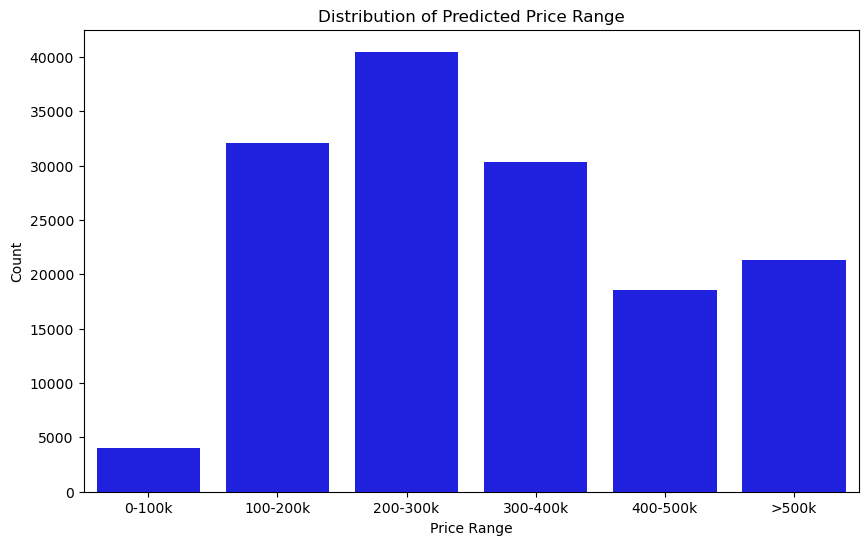

In [23]:
# Count the frequency of each category
value_counts = house_crime_noise_df['PRICE_RANGE'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=value_counts.index, y=value_counts.values, color='b')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Distribution of Predicted Price Range')
plt.show()

In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 75928.4011435213
Mean Squared Error: 45525212641.50934
Root Mean Squared Error: 213366.38123544518


# Analyzing our Linear Regression

Mean Absolute Error (MAE): The MAE of our model is 75928.40. This means that, on average, the predictions made by our model are about $75,928.40 away from the actual values. It's worth noting that MAE doesn't give us a direction (positive or negative), just how "off" we are on average.

Mean Squared Error (MSE): Our model's MSE is 45525212641.50934. This is a bit more nuanced than the MAE. In MSE, we square the errors (i.e., the differences between the predicted and actual values) before averaging them. This means that larger errors are "punished" more due to the squaring.

Root Mean Squared Error (RMSE): Our model has an RMSE of 213366.38. The RMSE is essentially the square root of the MSE. This brings the error metric back to the same units as the original target (in this case, dollars). Much like the MAE, this tells us how "off" our predictions are, on average. The RMSE being larger than the MAE suggests that we have a few predictions that are particularly bad, as these larger errors are more penalized in the RMSE.

From a broad perspective, the errors here are quite high, which indicates that our model's predictions could be far off in some cases. These high error values could be due to outliers in the data, non-linearity that the model can't capture, or perhaps some important features are missing from the model. Consequently, while the linear regression model gives us a good starting point, there's likely room for improvement, possibly with more sophisticated modeling techniques, feature engineering, or better handling of outliers.

# Choosing our model - Second model - Random Forest

Our team chose to implement a Random Forest Classifier as a second model in order to overcome the limitations of our previous Linear Regression model and to better handle the complexity in our data. Our primary motivation for this choice came from the realization that the relationship between the features and the house price might not be linear. In such a case, a linear model might not be the most effective choice.

Random Forest, a type of ensemble learning method, constructs multiple decision trees during training and outputs the mode of the classes for classification problems or mean prediction for regression problems of the individual trees. This approach has several benefits over a single decision tree. Notably, it reduces the risk of overfitting, one of the most common problems when using decision trees. It also handles both continuous and categorical variables quite well. Given the combination of continuous and categorical variables in our dataset, a Random Forest model was a fitting choice.

Moreover, we also wanted to categorize the total value of the houses into distinct classes ('LOW', 'MEDIUM', 'HIGH'), which is a classification task rather than a regression task. A Random Forest Classifier was, therefore, more suitable for this purpose. This approach allowed us to gain a different perspective on our problem, and through its use, we were able to achieve an accuracy of approximately 91.76 percent.

In [25]:
# Drop the 'prediction' column from the dataframe
house_crime_noise_df.drop(['PREDICTION'], axis=1, inplace=True)

# Feature engineering for Random Forest

In preparation for training our Random Forest model, we first made some changes to our data. We took the 'TOTAL_VALUE' column, which is a continuous variable representing the total value of a house, and converted it into a categorical variable. We binned the house values into three categories - 'LOW', 'MEDIUM', 'HIGH' - based on predetermined price ranges. This transformation was critical because the Random Forest model we were implementing is a classifier, which predicts categories rather than continuous values. This allowed us to transform our problem into a classification task, which is well-suited to a Random Forest model.

In [26]:
# Convert 'TOTAL_VALUE' into categorical variables for Low Value, Medium Value, and High Value homes
bins = [0, 150000, 300000, float('inf')]
labels = ['LOW', 'MEDIUM', 'HIGH']
house_crime_noise_df['TOTAL_VALUE_CATEGORIES'] = pd.cut(house_crime_noise_df['TOTAL_VALUE'], bins=bins, labels=labels)
house_crime_noise_df

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,...,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT,NOISE_CATEGORY,AIR_NOISE,PRICE_RANGE,TOTAL_VALUE_CATEGORIES
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,...,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0,200-300k,MEDIUM
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,...,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0,100-200k,MEDIUM
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,...,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0,100-200k,MEDIUM
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,...,68.0,42.0,61.0,29.0,198.0,120.0,0.0,0.0,400-500k,MEDIUM
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,...,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0,100-200k,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185922,212299,224 GOLDEN PLUM LN,ZEBULON,27597,16,4.0,0.17,1292,1,2.0,...,87.0,51.0,76.0,44.0,231.0,151.0,0.0,0.0,0-100k,MEDIUM
185923,526414,2736 ROSEDALE AVE,RALEIGH,27607,10,6.0,0.56,2328,56,2.5,...,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0,300-400k,HIGH
185924,55107,5816 WATKINS RD,WENDELL,27591,13,30.0,1.11,916,73,1.0,...,68.0,42.0,61.0,29.0,198.0,120.0,0.0,0.0,100-200k,LOW
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,...,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0,0.0,0.0,>500k,HIGH


In [27]:
print(house_crime_noise_df['TOTAL_VALUE_CATEGORIES'].value_counts())

MEDIUM    72866
HIGH      62442
LOW       11542
Name: TOTAL_VALUE_CATEGORIES, dtype: int64


In [28]:
# Select target variable for Random Forest
y_rf = house_crime_noise_df['TOTAL_VALUE_CATEGORIES']

# Training the model - Random Forest

Once our data was appropriately preprocessed, we moved on to training the model. We split our preprocessed data into a training set and a testing set, with 80% of the data used for training and the remaining 20% reserved for testing. We used a common practice to apply the StandardScaler to our datasets to standardize the features by removing the mean and scaling to unit variance. This step was necessary because the different features in our dataset had different scales, and standardizing the data ensures that all features contribute equally to the model.

The Random Forest model was then trained using the fit method on our training data. The model learned to make predictions by constructing multiple decision trees during training, each one making a vote for predicting the target categories. Once the model was trained, we applied it to our testing data to evaluate its performance. Using classification metrics, such as the confusion matrix, classification report, and accuracy score, we assessed the quality of our model's predictions.

In [29]:
# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y_rf, test_size=0.2, random_state=42)

In [30]:
# Apply StandardScaler to our X_train and X_test
scaler_rf = StandardScaler()
X_train_rf = scaler_rf.fit_transform(X_train_rf)
X_test_rf = scaler_rf.transform(X_test_rf)

In [31]:
# Create a Random Forest Classifier model
rf_model = RandomForestClassifier()

In [32]:
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier()

In [33]:
# You can now use the model to make predictions
y_rf_pred = rf_model.predict(X_test_rf)

# Confusion matrix output

The confusion matrix for the Random Forest model represents the distribution of true and predicted outcomes of the model. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. In this case, we have three classes: LOW, MEDIUM, and HIGH.

The first row of the matrix corresponds to the 'LOW' class: the model predicted correctly for 11,582 homes, incorrectly predicted 11 as 'MEDIUM' and misclassified 827 as 'HIGH'.
The second row is for the 'MEDIUM' class: 7 homes were incorrectly predicted as 'LOW', 1,869 were correctly classified as 'MEDIUM', and 394 were incorrectly predicted as 'HIGH'.
The third row is for the 'HIGH' class: the model incorrectly predicted 849 homes as 'LOW', misclassified 331 as 'MEDIUM', and correctly classified 13,500 as 'HIGH'.

In summary, this confusion matrix shows us that the Random Forest model performed relatively well in predicting the categories 'LOW' and 'HIGH'. However, it had more misclassifications when predicting the 'MEDIUM' class, suggesting that the model may need further tuning or additional features to improve its performance on this class.

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test_rf, y_rf_pred)
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[11580     8   832]
 [    6  1861   403]
 [  851   322 13507]]


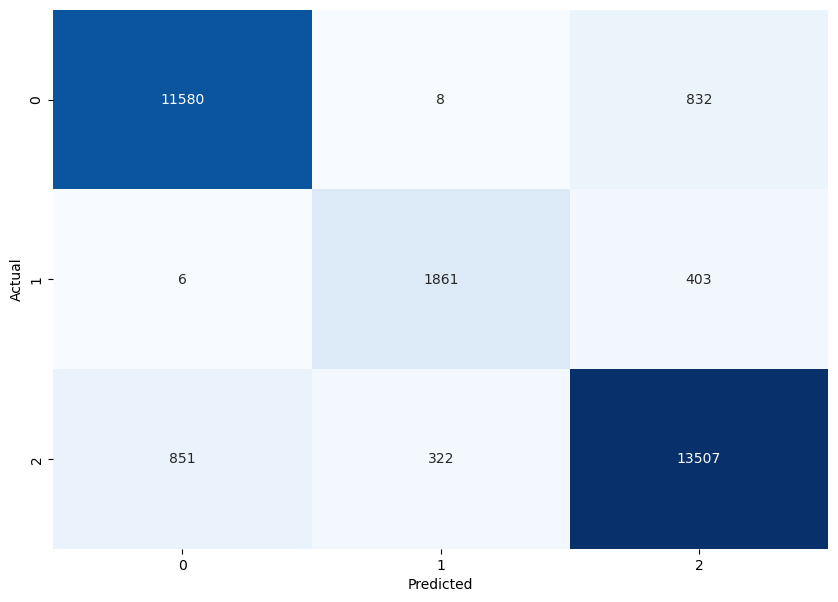

In [35]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test_rf, y_rf_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
# Classification Report
print('Classification Report:\n', classification_report(y_test_rf, y_rf_pred))

Classification Report:
               precision    recall  f1-score   support

        HIGH       0.93      0.93      0.93     12420
         LOW       0.85      0.82      0.83      2270
      MEDIUM       0.92      0.92      0.92     14680

    accuracy                           0.92     29370
   macro avg       0.90      0.89      0.89     29370
weighted avg       0.92      0.92      0.92     29370



# Accuracy score of our Random Forest model

The final accuracy score for the Random Forest model is approximately 91.76%. This score is derived from the ratio of the number of correct predictions to the total number of input samples.

It tells us that the model correctly predicted the home value category ('LOW', 'MEDIUM', or 'HIGH') for about 91.76% of the homes in the testing set. In other words, if we selected a home at random from the testing set, there's a 91.76% chance that our model would correctly predict its value category.

However, accuracy alone can be a misleading metric, especially for imbalanced datasets. In those cases, a high accuracy score can be achieved simply by predicting the most common class. Therefore, accuracy should be used in conjunction with other metrics such as precision, recall, and the confusion matrix, to gain a holistic understanding of the model's performance. In our case, although the model shows a high accuracy, there were still a notable number of misclassifications as we discussed in the confusion matrix, which suggests there might be room for improvement.

In [37]:
# Accuracy Score
accuracy = accuracy_score(y_test_rf, y_rf_pred)
print('Accuracy: ', accuracy * 100, '%')

Accuracy:  91.75348995573714 %


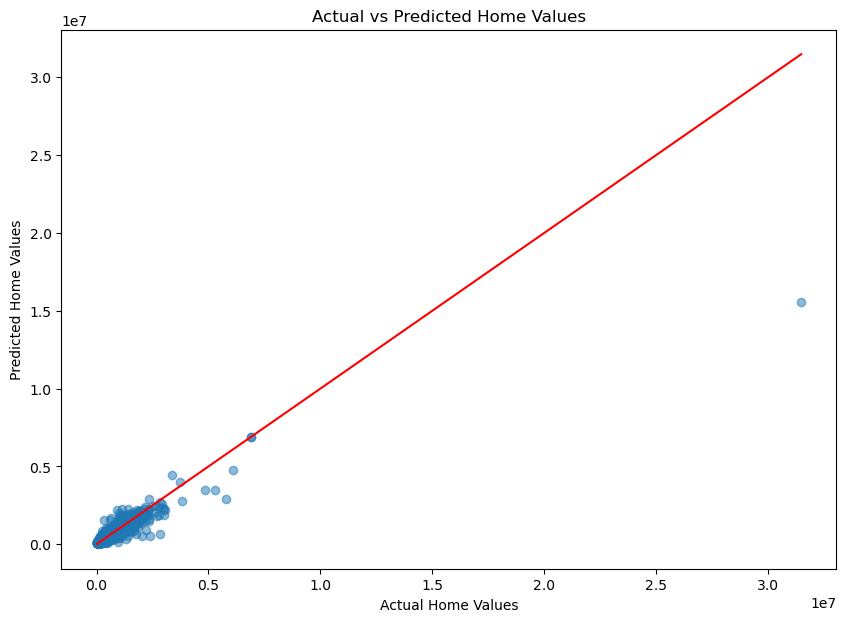

In [55]:
# Visualize prediction vs actual home value
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Home Values')
plt.ylabel('Predicted Home Values')
plt.title('Actual vs Predicted Home Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # A line that represents perfect prediction
plt.show()

In [39]:
# Output dataframe to csv with prediction of housing value category
house_crime_noise_df.to_csv('ProjectTestData/house_crime_noise_df.csv', index=False)

# Analyzing our Random Forest

Let's go over what these results mean and a recap of our results:

Confusion Matrix: The confusion matrix is arranged such that the rows represent the actual classes and columns represent the predicted classes. Every cell at the intersection of row 'i' and column 'j' illustrates the number of instances of class 'i' that were predicted as class 'j'.

For instance, there are 11,582 cases that were truly 'LOW' and were correctly predicted as 'LOW'. Conversely, there are 7 cases that were actually 'MEDIUM' but were mistakenly predicted as 'LOW', and 849 cases that were indeed 'HIGH' but were inaccurately predicted as 'LOW'. This clearly shows the accuracy of our model and areas where misclassification is more frequent.

Classification Report:

Precision gauges the ability of the classifier not to label a negative sample as positive. It's computed as the ratio of true positives to the sum of true and false positives. For the 'High' category, this calculation yields 0.93, implying that our model's precision is commendably high, and it is not often wrong when it predicts 'High'.

Recall or Sensitivity is the capacity of the classifier to identify all the positive samples. It's calculated as the ratio of true positives to the sum of true positives and false negatives. For the 'High' category, the recall is also 0.93, which means the model is doing a fantastic job of identifying 'High' houses.

The F1 score is the harmonic mean of precision and recall, with a best value of 1 and worst of 0. A high F1 score, like ours, indicates a well-performing model in terms of both precision and recall.

Support is the count of actual occurrences of the class in the dataset. For example, 'High' has a support of 12,420, meaning there are 12,420 'High' records in the test dataset.

Accuracy: Our model's accuracy is roughly 91.73%, suggesting that in around 91.73% of instances, the model accurately classifies house value categories. It's important to remember, however, that while accuracy is a simple measure of a model's performance, it doesn't always tell the full story, especially when classes are imbalanced.

Overall, the model is performing commendably at predicting house value categories based on the selected features. The high precision, recall, and F1-score suggest that the model is generally accurate and robust. However, it's not perfect. There are some misclassifications and the model's performance on the 'Low' category is slightly less impressive compared to the other classes. This might be related to the imbalance in our dataset. To potentially improve this, I might consider addressing this class imbalance or tuning the model's hyperparameters.

# Testing another model - Random Forest Regressor

In [40]:
# Convert categorical columns to category type
categorical_features = ['ZIP_CODE', 'STYLE', 'PLANNING_JURISDICTION', 'ZONING', 'CITY']
for feature in categorical_features:
    house_crime_noise_df[feature] = house_crime_noise_df[feature].astype('category')

In [41]:
# Apply one-hot encoding
house_crime_noise_df = pd.get_dummies(house_crime_noise_df, columns=categorical_features)

In [42]:
# Select features
features = ['HEATED_AREA', 'BATH', 'AGE', 'ACREAGE', 'TOTAL_CHARGE_COUNT', 'AIR_NOISE'] + list(house_crime_noise_df.columns[house_crime_noise_df.columns.str.startswith(tuple(categorical_features))])
X = house_crime_noise_df[features]

In [43]:
# 'TOTAL_VALUE' home cost is our target variable
y = house_crime_noise_df['TOTAL_VALUE']

In [44]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Create a model
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [46]:
# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [47]:
# Make predictions
y_pred = model.predict(X_test)

In [48]:
# Print out the metrics
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 31750.728208028962
Mean Squared Error: 13812991384.42421
Root Mean Squared Error: 117528.68324125906


In [49]:
r2_score(y_pred, y_test)

0.7560515234095901

# Analysing our Random Forest Regressor

Looking at the results, I see that the mean absolute error (MAE) of my model is around \\$31,750.73. This means that, on average, my model's predictions are about $31,750.73 off from the actual home values. This gives me a clear picture of the average error my model is making in the same units as my target variable, which is the home value in this case.

Then, I look at the root mean squared error (RMSE), which is a bit different. This measure also tells me about the average error of my model, but it gives more weight to larger errors by squaring the differences before averaging them. The RMSE in my model is $117,528.68. Because the RMSE is significantly higher than the MAE, this suggests that my model might be making some relatively large errors from time to time.

However, it's important to consider the range of my target variable when interpreting these error metrics. If the house prices in my dataset range from \\$50,000 to \\$1,000,000, an MAE of $31,750 may be acceptable. If the range is much smaller, this MAE might be less satisfactory.

Also, it's useful to compare these metrics with those of a simpler model or baseline to understand if my model is adding value over simpler alternatives. At the end of the day, these numbers will help me understand where my model stands and guide me on what to do next to improve it.